### Option Pricing using Monte Carlo method and AR(1) with stochastic drift

Assuming stock price is at time $t$:

$ S_t = \beta_0 + \beta_1 t + \beta_2 S_{t-1} + u_t $

where $u_t$ ~ $N(0, \sigma_u^2)$, and drift term $\beta_0$ ~ $N(\hat{\beta_0}, \sigma_{\hat{\beta_0}}^2) $


In [125]:
import yfinance as yf
import pandas as pd
import numpy as np
import json
import datetime as dt
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm


In [148]:
stock = "AKER BP"
ticker = "AKRBP.OL"
today = dt.datetime.today()

df = yf.download(ticker, start='2023-01-01', end=today, period='1d')
df.reset_index(inplace=True)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
483,2024-12-02,225.399994,226.600006,222.399994,222.699997,222.699997,875701
484,2024-12-03,225.000000,230.600006,224.600006,230.500000,230.500000,1124816
485,2024-12-04,231.500000,234.100006,230.600006,230.699997,230.699997,1011435
486,2024-12-05,230.000000,231.100006,227.500000,228.500000,228.500000,881180
487,2024-12-06,228.100006,228.800003,219.199997,219.600006,219.600006,1242465


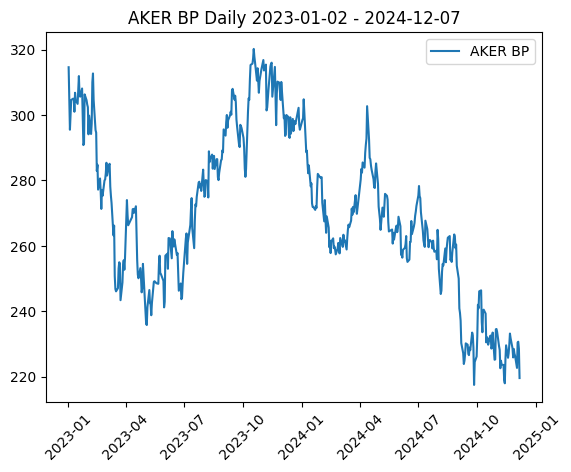

In [149]:
plt.plot(df['Date'], df['Close'], label=stock)
plt.legend()
plt.xticks(rotation=45)
plt.title(f'{stock} Daily {df.loc[0, "Date"].date()} - {today.date()}')
plt.show()

In [150]:
t = [i+1 for i in range(len(df)-1)]
S = np.array(df['Close'])
S_lag = S[0:-1]
S = S[1:]
vol = np.sqrt(np.var(S))

X = pd.DataFrame({'Time': t, 'S_lag': S_lag})
X = sm.add_constant(X)

S_m = sm.OLS(S, X).fit()

coefs = S_m.params
sde = S_m.bse
ser = np.sqrt(S_m.mse_resid)
R2 = S_m.rsquared

S_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     6610.
Date:                Sat, 07 Dec 2024   Prob (F-statistic):               0.00
Time:                        22:42:31   Log-Likelihood:                -1441.9
No. Observations:                 487   AIC:                             2890.
Df Residuals:                     484   BIC:                             2902.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.5932      2.912      2.264      0.024       0.871      12.315
Time          -0.0022      0.002     -1.261      0.208      -0.006       0.001
S_lag          0.9769      0.010     98.967      0.000       0.957       0.996
==============================================================================
Omnibus:                       11.410   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               20.557
Skew:                           0.061   Prob(JB):                     3.44e-05
Kurtosis:                       3.999   Cond. No.                     5.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Drift analysis


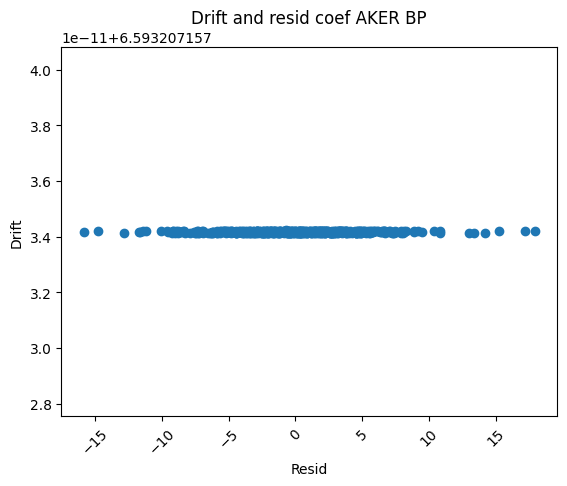

,Drift,Resid
Drift,1.000000,0.048981
Resid,0.048981,1.000000


In [151]:
drift_t = [S[i] - t[i]*coefs['Time'] - S_lag[i]*coefs['S_lag'] - np.array(S_m.resid)[i] for i in range(len(S))]
resid_t = S_m.resid
drift_resid = pd.DataFrame({"Drift": drift_t, "Resid": resid_t})

plt.scatter(resid_t, drift_t, label=f"Drift and Residual terms {stock}")
plt.xticks(rotation=45)
plt.xlabel("Resid")
plt.ylabel("Drift")
plt.title(f"Drift and resid coef {stock}")
plt.show()
drift_resid.corr()

### Model for Random Walk with stochastic drift

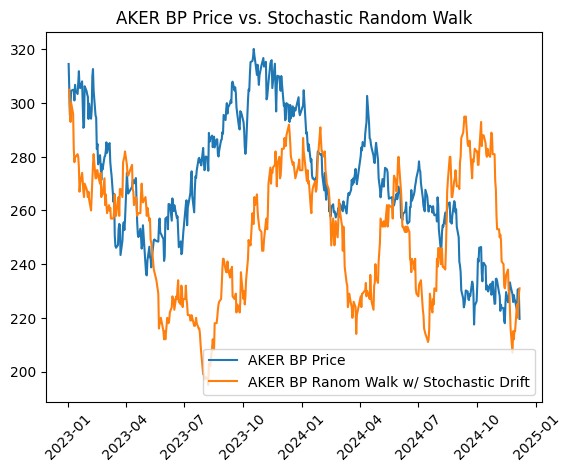

(24.46267531455807, 24.865875038945614)

In [152]:
N = len(S)

S_t = np.repeat(0, N)
S_t[0] = S[0]
for j in range(N-1):
    drift = np.random.normal(coefs['const'], 0.5*sde['const'])
    u = ser*np.random.normal()
    L = np.linalg.cholesky(drift_resid.corr())
    d_t, u_t = np.inner(L, np.array([drift, u]))
    S_t[j+1] = d_t + j*coefs['Time'] + S_t[j]*coefs['S_lag'] + u_t

plt.plot(df['Date'], df['Close'], label = f"{stock} Price")
plt.plot(df['Date'][1:], S_t, label = f"{stock} Ranom Walk w/ Stochastic Drift")
plt.xticks(rotation=45)
plt.legend()
plt.title(f"{stock} Price vs. Stochastic Random Walk")
plt.show()

(np.sqrt(np.var(S_t)), vol)

### Monte Carlo Model

Call Option Price of AKER BP w/ Strike @ 220: NOK 7.88 +- 0.32
Put Option Price of AKER BP w/ Strike @ 220: NOK 5.27 +- 0.28


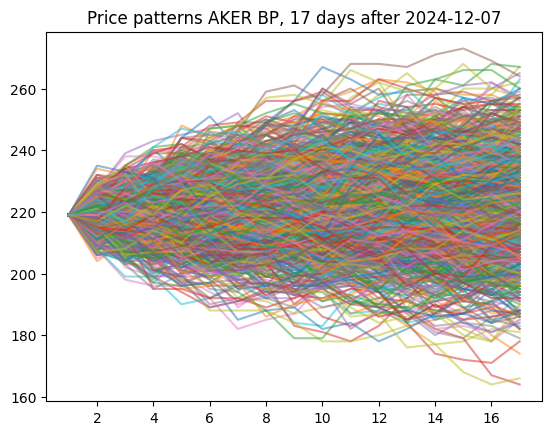

In [154]:
K = 220
T = 17
M = 1000
r = 0.045
y = T/365

paths = []
Cs = []
Ps = []

for i in range(M):
    S_t = np.repeat(0, T)
    S_t[0] = S[-1]
    for j in range(T-1):
        drift = np.random.normal(coefs['const'], 0.5*sde['const'])
        u = ser*np.random.normal()
        L = np.linalg.cholesky(drift_resid.corr())
        dift, u_t = np.dot(L, np.array([drift, u]))
        S_t[j+1] = drift + (j+N)*coefs['Time'] + S_t[j]*coefs['S_lag'] + u_t

    Ct = max(0, S_t[-1] - K)
    C0 = np.exp(-r*y)*Ct
    Cs.append(C0)

    Pt = max(0, K - S_t[-1])
    P0 = np.exp(-r*y)*Pt
    Ps.append(P0)
    paths.append(S_t)
    plt.plot(range(1, T+1), S_t, alpha=0.5)

C0 = round(np.mean(Cs), 2)
sde_c = round(np.sqrt(np.var(Cs))/np.sqrt(M), 2)
P0 = round(np.mean(Ps), 2)
sde_p = round(np.sqrt(np.var(Ps))/np.sqrt(M), 2)

print(f"Call Option Price of {stock} w/ Strike @ {K}: NOK {C0} +- {sde_c}")
print(f"Put Option Price of {stock} w/ Strike @ {K}: NOK {P0} +- {sde_p}")
plt.title(f"Price patterns {stock}, {T} days after {today.date()}")
plt.show()

### Value at Risk

95% confidence interval: [-14.54%, 14.58%]


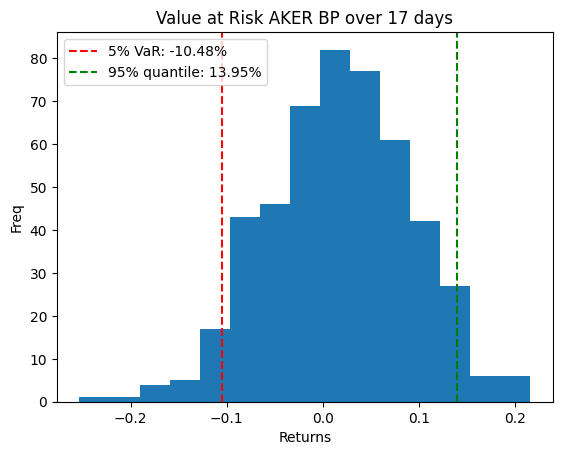

In [155]:
returns = [paths[i][-1] / S[-1] -1 for i in range(N)]
mu_r = np.mean(returns)
sd_r = np.sqrt(np.var(returns))
_5q = stats.norm.isf(0.95, mu_r, sd_r)
_95q = stats.norm.isf(0.05, mu_r, sd_r)


plt.hist(returns, 15)
plt.axvline(_5q, color="red", linestyle="--", label=f"5% VaR: {round(_5q*100, 2)}%")
plt.axvline(_95q, color="green", linestyle="--", label=f"95% quantile: {round(_95q*100, 2)}%")
plt.xlabel("Returns")
plt.ylabel("Freq")
plt.legend()
plt.title(f"Value at Risk {stock} over {T} days")
print(f"95% confidence interval: [{round(mu_r-1.96*sd_r*100, 2)}%, {round(mu_r+1.96*sd_r*100, 2)}%]")
plt.show()